In [2]:
import numpy as np
import open3d as o3d

class PointCloudVisualizer:
    def __init__(self, point_size: float = 1.0):
        """
        Visualizer class for rendering point clouds using Open3D with color-coded semantic labels.

        Args:
            point_size (float): Default size of points in the Open3D viewer.
        """
        self.point_size = point_size
        self.fixed_colors_rgb = self._get_fixed_colors_rgb()

    def _get_fixed_colors_rgb(self) -> "dict[int, list[float]]":
        fixed_colors = {
            -1: [255, 255, 255],  # plane
             0: [0, 0, 0],        # unlabeled
             1: [245, 150, 100],  # car
             2: [245, 230, 100],  # bicycle
             3: [150, 60, 30],    # motorcycle
             4: [180, 30, 80],    # truck
             5: [250, 80, 100],   # other-vehicle
             6: [30, 30, 255],    # person
             7: [200, 40, 255],   # bicyclist
             8: [90, 30, 150],    # motorcyclist
             9: [255, 0, 255],    # road
            10: [255, 150, 255],  # parking
            11: [75, 0, 75],      # sidewalk
            12: [75, 0, 175],     # other-ground
            13: [0, 200, 255],    # building
            14: [50, 120, 255],   # fence
            15: [0, 175, 0],      # vegetation
            16: [0, 60, 135],     # trunk
            17: [80, 240, 150],   # terrain
            18: [150, 240, 255],  # pole
            19: [0, 0, 255],      # traffic-sign
        }
        return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

    def _get_color_map(self, labels: np.ndarray) -> np.ndarray:
        """
        Assigns RGB colors to labels.

        Args:
            labels (np.ndarray): Array of label ids.

        Returns:
            np.ndarray: Nx3 array of RGB colors.
        """
        color_map = np.zeros((labels.shape[0], 3))
        for i, label in enumerate(labels):
            if label in self.fixed_colors_rgb:
                color_map[i] = self.fixed_colors_rgb[label]
            else:
                np.random.seed(label)
                color_map[i] = np.random.rand(3)
        return color_map
    
    def create_grid(self, size=50, spacing=1.0):
        points = []
        lines = []
        colors = []
    
        for i in range(-size, size + 1):
            # Linhas paralelas ao eixo X
            points.append([i * spacing, -size * spacing, 0])
            points.append([i * spacing, size * spacing, 0])
            lines.append([len(points) - 2, len(points) - 1])
    
            # Linhas paralelas ao eixo Y
            points.append([-size * spacing, i * spacing, 0])
            points.append([size * spacing, i * spacing, 0])
            lines.append([len(points) - 2, len(points) - 1])
    
            # Cores: mais clara a cada 10 unidades
            color = [0.3, 0.3, 0.3] if i % 10 else [0.6, 0.6, 0.6]
            colors.extend([color, color])
    
        grid = o3d.geometry.LineSet()
        grid.points = o3d.utility.Vector3dVector(points)
        grid.lines = o3d.utility.Vector2iVector(lines)
        grid.colors = o3d.utility.Vector3dVector(colors)
        return grid

    def show(
        self,
        point_cloud: np.ndarray,
        show_true_label: bool = False,
        show_ground: bool = True,
        show_clusters: bool = True,
        show_unlabeled: bool = True,
        show_plane: bool = False,
        point_size: float | None = None,
        show_grid: bool = True
    ) -> None:
        """
        Visualize the filtered point cloud using Open3D.

        Args:
            point_cloud (np.ndarray): N x 6 array [x, y, z, true_label, pred_label, scanline_id].
        """

        label_col = 3 if show_true_label else 4
        labels = point_cloud[:, label_col]

        # Apply filter mask
        mask = (
            (show_plane & (labels == -1)) |
            (show_unlabeled & (labels == 0)) |
            (show_ground & (labels == 9)) |
            (show_clusters & (labels >= 1) & (labels != 9))
        )

        xyz = point_cloud[mask, :3]
        visible_labels = labels[mask].astype(int)
        colors = self._get_color_map(visible_labels)

        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(xyz)
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Visualize with point size
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(pcd)
        if show_grid:
            vis.add_geometry(self.create_grid(size=50, spacing=1.0))  # grid grande com espaçamento 1m
        # vis.add_geometry(self.create_grid(size=20, spacing=1.0))  # Ajuste como quiser

        opt = vis.get_render_option()
        opt.point_size = point_size or self.point_size
        opt.background_color = np.asarray([0.1, 0.1, 0.1])  # estilo AutoCAD / pptk

        vis.run()
        vis.destroy_window()

point_cloud_array = np.load('frame_segmentado_slr_igual-2.npy')

visualizer = PointCloudVisualizer(point_size=3.0)
visualizer.show(point_cloud_array, show_true_label=True, show_ground=False, show_grid=False)

✅ Open3D Commands:
  [Mouse]  Botão esquerdo: Rotacionar
  [Mouse]  Botão direito: Zoom
  [Mouse]  Roda do mouse: Aproximar/Afastar
  [Q]      Sair
  [R]      Resetar câmera
  [S]      Screenshot (salva como 'ScreenShot.png')
  [P]      Mostrar/ocultar menu de visualização
  [Ctrl+C] Fechar terminal


In [3]:
import open3d as o3d
import numpy as np

# Função para criar um plano
def create_plane(width, height):
    # Criando os vértices de um plano
    vertices = np.array([
        [-width / 2, -height / 2, 0],  # Vértice inferior esquerdo
        [ width / 2, -height / 2, 0],  # Vértice inferior direito
        [ width / 2,  height / 2, 0],  # Vértice superior direito
        [-width / 2,  height / 2, 0],  # Vértice superior esquerdo
    ])
    
    # Criando os triângulos que formam o plano (2 triângulos)
    triangles = np.array([
        [0, 1, 2],  # Triângulo inferior
        [0, 2, 3]   # Triângulo superior
    ])
    
    # Criando o plano como um objeto TriangleMesh
    plane = o3d.geometry.TriangleMesh()
    plane.vertices = o3d.utility.Vector3dVector(vertices)
    plane.triangles = o3d.utility.Vector3iVector(triangles)
    
    # Calculando as normais dos vértices
    plane.compute_vertex_normals()
    
    return plane

# Criando um plano de 2x2
plane = create_plane(2.0, 2.0)

# Criando a janela de visualização
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Plano")
vis.add_geometry(plane)

# Exibindo a visualização
vis.run()
vis.destroy_window()


In [ ]:
import pyvista as pv
import numpy as np

class PointCloudVisualizer:
    def __init__(self, point_size: float = 0.03):
        """
        A visualizer class for rendering point clouds using PyVista with color-coded semantic labels.

        Args:
            point_size (float): Default size of points in the viewer.
        """
        self.point_size: float = point_size
        self.fixed_colors_rgb: "dict[int, list[float]]" = self._get_fixed_colors_rgb()

    def _get_fixed_colors_rgb(self) -> "dict[int, list[float]]":
        """
        Returns a dictionary mapping label ids to normalized RGB colors.
        The colors follow the SemanticKITTI color convention (converted from BGR to RGB).

        Returns:
            dict: {label: [R, G, B]} with values in [0, 1].
        """
        fixed_colors = {
            -1: [255, 255, 255],  # plane
             0: [0, 0, 0],        # unlabeled
             1: [245, 150, 100],  # car
             2: [245, 230, 100],  # bicycle
             3: [150, 60, 30],    # motorcycle
             4: [180, 30, 80],    # truck
             5: [250, 80, 100],   # other-vehicle
             6: [30, 30, 255],    # person
             7: [200, 40, 255],   # bicyclist
             8: [90, 30, 150],    # motorcyclist
             9: [255, 0, 255],    # road
            10: [255, 150, 255],  # parking
            11: [75, 0, 75],      # sidewalk
            12: [75, 0, 175],     # other-ground
            13: [0, 200, 255],    # building
            14: [50, 120, 255],   # fence
            15: [0, 175, 0],      # vegetation
            16: [0, 60, 135],     # trunk
            17: [80, 240, 150],   # terrain
            18: [150, 240, 255],  # pole
            19: [0, 0, 255],      # traffic-sign
        }
        return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

    def _get_color_map(self, unique_labels: np.ndarray) -> "list[list[float]]":
        """
        Generate a color map for a set of unique labels.
        If a label is not found in the fixed colors, generate a consistent random color.
    
        Args:
            unique_labels (np.ndarray): Unique label ids to assign colors to.
    
        Returns:
            list: List of RGB color triplets.
        """
        color_map = []
        for label in unique_labels:
            label = int(label)  # Certifique-se de que o label seja convertido para inteiro
            if label in self.fixed_colors_rgb:
                color_map.append(self.fixed_colors_rgb[label])
            else:
                np.random.seed(label)  # deterministic color per label
                color_map.append(np.random.rand(3))
        return color_map


    def show(self, point_cloud: np.ndarray, show_true_label: bool = False, point_size: float = None) -> None:
        """
        Show a point cloud with selected label filters.

        Args:
            point_cloud (np.ndarray): N x 6 array with columns [x, y, z, true_label, pred_label, scanline_index].
            show_true_label (bool): If True, use true labels (column 4); otherwise, use predicted labels (column 5).
            point_size (float): Override default point size.
        """
        label_col = 3 if show_true_label else 4
        labels = point_cloud[:, label_col]

        # Map labels to their respective colors
        unique_labels = np.unique(labels)
        color_map = self._get_color_map(unique_labels)

        # Create a PyVista plotter
        plotter = pv.Plotter()

        # Create a point cloud with colors mapped to labels
        points = point_cloud[:, :3]
        colors = np.array([color_map[np.where(unique_labels == label)[0][0]] for label in labels])

        # Create a PyVista mesh from the points and apply colors
        cloud = pv.PolyData(points)
        cloud.point_arrays["Colors"] = colors
        cloud.set_active_vectors("Colors")

        # Add the cloud to the plotter and set point size
        plotter.add_mesh(cloud, point_size=point_size or self.point_size)

        # Show the plotter
        plotter.show()


point_cloud_array = np.load('frame_segmentado_slr_igual-2.npy')

visualizer = PointCloudVisualizer(point_size=3.0)
visualizer.show(point_cloud_array, show_true_label=False)

In [59]:
import numpy as np
import pyvista as pv

# Função para obter o seu color map personalizado
def get_fixed_color_map():
    fixed_colors = {
        -1: [255, 255, 255],  # plane
         0: [0, 0, 0],        # unlabeled
         1: [245, 150, 100],  # car
         2: [245, 230, 100],  # bicycle
         3: [150, 60, 30],    # motorcycle
         4: [180, 30, 80],    # truck
         5: [250, 80, 100],   # other-vehicle
         6: [30, 30, 255],    # person
         7: [200, 40, 255],   # bicyclist
         8: [90, 30, 150],    # motorcyclist
         9: [255, 0, 255],    # road
        10: [255, 150, 255],  # parking
        11: [75, 0, 75],      # sidewalk
        12: [75, 0, 175],     # other-ground
        13: [0, 200, 255],    # building
        14: [50, 120, 255],   # fence
        15: [0, 175, 0],      # vegetation
        16: [0, 60, 135],     # trunk
        17: [80, 240, 150],   # terrain
        18: [150, 240, 255],  # pole
        19: [0, 0, 255],      # traffic-sign
    }
    return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

# Geração de uma nuvem de pontos fictícia (substitua pela sua real)
point_cloud = np.load('frame_segmentado_slr_igual-2.npy')
# labels = np.random.choice(list(LABEL_COLORS.keys()), size=N)
# point_cloud[:, 3] = labels
xyz = point_cloud[:, :3]
labels = point_cloud[:, 3]


# Mapear as cores usando o seu colormap
color_map = get_fixed_color_map()
colors = np.array([color_map.get(label, [0.5, 0.5, 0.5]) for label in labels])

# Criar objeto PyVista
cloud = pv.PolyData(xyz)
cloud["Colors"] = colors

# Criar plotter com fundo cinza, grid e pontos como esferas
plotter = pv.Plotter()
plotter.window_size = [900, 500]  # Tamanho da janela 800x600 pixels
plotter.set_background("gray")  # Fundo cinza
plotter.show_grid()             # Mostrar grid
plotter.add_mesh(
    cloud,
    scalars="Colors",
    rgb=True,
    point_size=3.0,  # Tamanho do ponto
    render_points_as_spheres=True  # Pontos como esferas
)
plotter.show()


Widget(value='<iframe src="http://localhost:46019/index.html?ui=P_0x7fe36eae74d0_33&reconnect=auto" class="pyv…

In [50]:
import numpy as np
import pyvista as pv

# Seu colormap, convertido conforme sua lógica (reversed RGB e normalizado)
def get_label_colors():
    fixed_colors = {
        -1: [255, 255, 255],  # plane
         0: [0, 0, 0],        # unlabeled
         1: [245, 150, 100],  # car
         2: [245, 230, 100],  # bicycle
         3: [150, 60, 30],    # motorcycle
         4: [180, 30, 80],    # truck
         5: [250, 80, 100],   # other-vehicle
         6: [30, 30, 255],    # person
         7: [200, 40, 255],   # bicyclist
         8: [90, 30, 150],    # motorcyclist
         9: [255, 0, 255],    # road
        10: [255, 150, 255],  # parking
        11: [75, 0, 75],      # sidewalk
        12: [75, 0, 175],     # other-ground
        13: [0, 200, 255],    # building
        14: [50, 120, 255],   # fence
        15: [0, 175, 0],      # vegetation
        16: [0, 60, 135],     # trunk
        17: [80, 240, 150],   # terrain
        18: [150, 240, 255],  # pole
        19: [0, 0, 255],      # traffic-sign
    }
    return {label: [c / 255.0 for c in reversed(rgb)] for label, rgb in fixed_colors.items()}

LABEL_COLORS = get_label_colors()

# Função para obter cor de rótulo
def label_to_color(label):
    return LABEL_COLORS.get(label, [1.0, 1.0, 1.0])  # fallback: branco

# Gerar pontos sintéticos com rótulos
N = 2000
point_cloud = np.load('frame_segmentado_slr_igual-2.npy')
# labels = np.random.choice(list(LABEL_COLORS.keys()), size=N)
# point_cloud[:, 3] = labels
labels = point_cloud[:, 3]

# Mapear rótulos para cores
colors = np.array([label_to_color(int(label)) for label in labels])

# Criar a nuvem de pontos com PyVista
cloud = pv.PolyData(point_cloud[:, :3])
cloud.point_data["Colors"] = colors

# Visualizar
plotter = pv.Plotter()
plotter.add_mesh(cloud, scalars="Colors", rgb=True, point_size=5)
plotter.window_size = [900, 500]  # Tamanho da janela 800x600 pixels
plotter.show()


Widget(value='<iframe src="http://localhost:46019/index.html?ui=P_0x7fe29ff78650_26&reconnect=auto" class="pyv…

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
import numpy as np
import plotly.graph_objects as go
@interact
def foo(beta=(-10,10,1)):
    myx = np.arange(0,100,1)
    myy = myx *beta 
    print ('debug:',myy)
    fig = go.FigureWidget()
    fig.add_scatter(x= myx, y=myy)
    fig.show()


In [ ]:
import pyvista as pv
pv.set_jupyter_backend('trame')  

# Criação de uma esfera simples
sphere = pv.Sphere()
plotter = pv.Plotter()
plotter.add_mesh(sphere)
plotter.show()


In [ ]:
import pyvista as pv
import numpy as np

# Criar uma nuvem de pontos simulada (substitua com seus dados)
num_points = 100000
points = np.random.rand(num_points, 3)

# Criar o objeto de nuvem de pontos
point_cloud = pv.PolyData(points)

# Criar um plotter interativo
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, color="blue", point_size=1)

# Exibir a visualização interativa
plotter.show()


In [31]:
import pyvista as pv

# Criação do objeto Plotter
plotter = pv.Plotter()

# Adicionando uma malha (exemplo: esfera)
sphere = pv.Sphere()
plotter.add_mesh(sphere)

# Definindo o tamanho da janela (largura x altura em pixels)
plotter.window_size = [500, 500]  # Tamanho da janela 800x600 pixels

# Mostrando a visualização
plotter.show()


Widget(value='<iframe src="http://localhost:46019/index.html?ui=P_0x7fe31c221590_14&reconnect=auto" class="pyv…

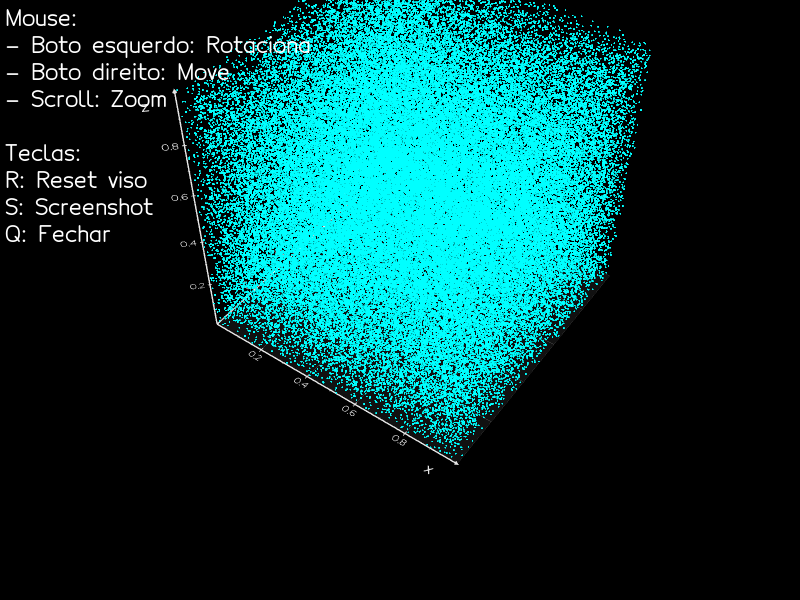

In [12]:
import numpy as np
from vedo import Points, show, Text2D

# Gera pontos
points = np.random.rand(100000, 3)

# Cria nuvem de pontos
cloud = Points(points, r=2, c="cyan")

# Legenda de comandos na tela
info = Text2D("Mouse:\n- Botão esquerdo: Rotaciona\n- Botão direito: Move\n- Scroll: Zoom\n\nTeclas:\nR: Reset visão\nS: Screenshot\nQ: Fechar", pos='top-left', c='white')

# Exibe janela interativa
show(cloud, info, axes=1, bg='black', viewup='z', title="Vedo Point Cloud Viewer")


In [ ]:
import numpy as np
from vedo import Points, show, Text2D

# Gera pontos
points = np.random.rand(100000, 3)

# Cria nuvem de pontos
cloud = Points(points, r=2, c="cyan")

# Legenda de comandos na tela
info = Text2D("Mouse:\n- Botão esquerdo: Rotaciona\n- Botão direito: Move\n- Scroll: Zoom\n\nTeclas:\nR: Reset visão\nS: Screenshot\nQ: Fechar", pos='top-left', c='white')

# Exibe janela interativa
show(cloud, info, axes=1, bg='black', viewup='z', title="Vedo Point Cloud Viewer")


2d


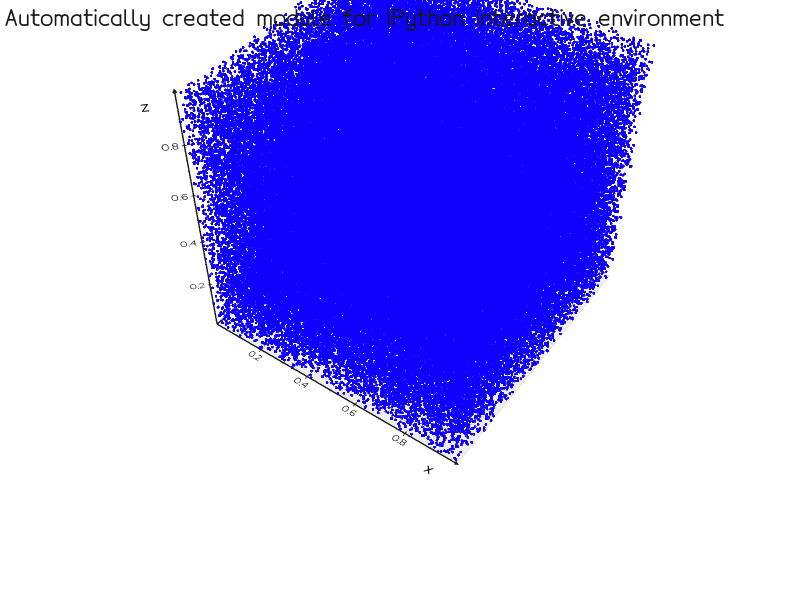

In [15]:
import numpy as np
from vedo import Points, show
import vedo

print(vedo.settings.default_backend)

# Gera 150.000 pontos aleatórios em 3D
num_points = 150000
points = np.random.rand(num_points, 3)

# Cria objeto de pontos com vedo
cloud = Points(points, r=3, c="blue")  # r = raio dos pontos, c = cor

# Exibe
show(cloud, __doc__, axes=1, viewup="z")  # viewup="z" ajusta a orientação da câmera


In [ ]:
import open3d as o3d
import open3d.visualization.gui as gui
import open3d.visualization.rendering as rendering
import numpy as np

class PointCloudApp:
    def __init__(self, pcd_array: np.ndarray):
        self.pcd = self.numpy_to_o3d(pcd_array)

        # Inicializa GUI
        gui.Application.instance.initialize()

        self.window = gui.Application.instance.create_window(
            "Open3D PointCloud Viewer (FPS-style)", 1024, 768
        )
        self.scene = gui.SceneWidget()
        self.scene.scene = rendering.Open3DScene(self.window.renderer)
        self.window.add_child(self.scene)

        # Configurações da cena
        self.scene.scene.set_background([0, 0, 0, 1])  # Preto
        self.scene.scene.add_geometry("pcd", self.pcd, rendering.MaterialRecord())
        bounds = self.pcd.get_axis_aligned_bounding_box()
        self.scene.setup_camera(60, bounds, bounds.get_center())

        # Estilo FPS: mover com teclado e rotacionar com mouse
        self.scene.set_view_controls(gui.SceneWidget.Controls.FLY)  # Estilo "fly"

        # Ajuda
        self.add_help_text()

    def numpy_to_o3d(self, points: np.ndarray) -> o3d.geometry.PointCloud:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:, :3])

        if points.shape[1] >= 5:
            # Converte pred_label para cores
            colors = self.label_to_color(points[:, 4].astype(int))
            pcd.colors = o3d.utility.Vector3dVector(colors)
        return pcd

    def label_to_color(self, labels: np.ndarray) -> np.ndarray:
        unique = np.unique(labels)
        np.random.seed(42)
        color_map = {label: np.random.rand(3) for label in unique}
        return np.array([color_map[label] for label in labels])

    def add_help_text(self):
        em = self.window.theme.font_size
        margins = gui.Margins(0.5 * em, em, 0.5 * em, 0.5 * em)
        label = gui.Label("Use W/A/S/D/Q/E para mover a câmera\n"
                          "Mouse para girar\n"
                          "Scroll para zoom\n"
                          "ESC para sair")
        label.frame = gui.Rect(10, 10, 400, 100)
        self.window.add_child(label)

    def run(self):
        gui.Application.instance.run()


# Teste com um array de exemplo (Nx6: x, y, z, true_label, pred_label, scan_id)
if __name__ == "__main__":
    num_points = 10000
    cloud = np.random.rand(num_points, 6).astype(np.float32)
    cloud[:, :3] *= 10  # [x, y, z]
    cloud[:, 4] = np.random.randint(0, 20, num_points)  # pred_label

    app = PointCloudApp(cloud)
    app.run()
